# No-show appointment forecasting

**Author**: Joseph Blue

**Version date**: June 15 2023

## Overview

Many people are guilty of having canceled a doctor’s appointment. However, although canceling an appointment does not seem too disastrous from the patient’s point of view, no-shows cost outpatient health centers a staggering 14% of anticipated daily revenue (JAOA). Missed appointments trickle into lower utilization rates for not only doctors and nurses but also the overhead costs required to run outpatient centers. In addition, patients missing their appointments risk facing poorer health outcomes as they are unable to access timely care. While outpatient centers employ solutions such as calling patients ahead of time, these high touch resources investments are often not prioritized for patients with the highest risk of no-shows. Low touch solutions such as automated texts are effective tools for mass reminders but do not offer necessary personalization for patients at the highest risk of no-shows.

**Use case type**: Health Care, No-show forecasting

**Complexity**: Business analyst

**Strategy**: Identify clients likely to attend appointments ("no-shows") and take action to prevent that from happening

**How AI helps**: Improve execution performance and demonstrate the best execution

**Business drivers**: Grow revenue, increase customer LTV, and increase customer satisfaction

**Desired outcomes**: <ul><li>Prevent no-shows</li><li>Optimally target responses</li><li>Reduce costs from missed appointments</li><li>Add revenue from booking more appointments</li></ul>

**Metrics and KPIs**: <ul><li>Current no-show rate. Roughly 5% of all appointments are "no-show".</li><li>Cost of missed visit. On average, a missed visit costs the health care provider $150 per missed appointment.</li></ul>

**Model usage**: Rank order patients based on P(no-show) to prevent loss of revenue and potentially to overbook visits to prevent down-time.

#### Sample datasets

* [no_show.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/no_show.csv)
* [clinics.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/clinics.csv)
* [planning_neighborhoods.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/planning_neighborhoods.csv)
* [no_show_historical.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/no_show_historical.csv)

### Solution value

AI enables your practice management staff to predict in advance which patients are likely to miss their appointments. By learning from historical data to uncover patterns related to no-shows, AI also provides your outpatient staff members with the top reasons why patients are likely to miss their appointments. These predictions and their explanations help your staff understand how various factors, such as a patient’s distance from a clinic and the days they needed to wait for their appointments, influence their risk of no-shows. Based on these predictions and insights, outpatient staff members can focus their outreach on patients with the highest risk of no-shows and offer them with solutions such as rescheduling their appointments or providing them with transportation.

The primary opportunities that this use case addresses are outlined in the table below.

| Issue | Opportunity |
|------ | ------------|
| Patient outcome | Patients suffer if they do not get the care they require. Ensuring attendance plays a critical role in patient health. |
| Revenue loss | A degree of certainty about an open booking slot allows for preemptive filling by:<ul><li>Standard over-booking.</li><li>Using a "propensity for" model to contact an alternative patient.</li></ul>|
| Staffing inefficiency | Correct staffing levels improve both patient and employee satisfaction.|



## Setup

### Import libraries

In [1]:
# Install the shapely and datarobot libraries
!pip install shapely --quiet
#!pip install datarobot --quiet 

import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import shapely.wkt
import shapely.geometry
import os
from IPython.display import HTML
import json
import requests
import yaml

%matplotlib inline

### Prepare data

#### Shape

The dataset for this use case consists of patient visits (one row per visit). For best results, the data should cover two years of historical appointments. This time window should include a complete sample of your data, accounting for seasonality and other important factors like COVID. Sampling at the patient ID, instead of the appointment ID, should be done so all appointments for a particular patient are present.

#### Features
Your dataset should contain, minimally, the following features:

- Patient ID
- Binary classification target (`show/no-show`, `0/1`, `True/False`, etc.)
- Date/time of the scheduled appointment
- Date the appointment was made
- The number of days between the appointment and when it was scheduled

Other helpful features to include are:

- Distance between the patient and the clinic they are visiting
- Historical no-show rates for the patient
- Reason for visit
- Clinic they are visiting
- The doctor they are visiting
- The age of the patient
- The gender of the patient
- Other factors about the patient (hypertension, diabetes, alcholism, etc.)

#### Example data

This accelerator contains robust sample data that gives an example of what features one might need. The following sections will walk you through preparing typical data and adding features that will allow your model to perform better.

In [2]:
# Function definition for data used at prediction time

def data_prep_sample(sample_df):
    sample_df['Schedule Date'] = pd.to_datetime(sample_df['Schedule Date'])
    sample_df['Appointment Date'] = pd.to_datetime(sample_df['Appointment Date'])

    # calulate the schedule delta between scheduled day and appointment day. Empty out the time so we are just left with days
    sample_df["Appointment/Schedule Delta"] = (sample_df['Appointment Date'] - sample_df['Schedule Date'].apply(lambda t : t.replace(minute=0, hour=0, second=0, microsecond=0))).apply(lambda t: t.days)

    # Calculate a new column that is the distance between the neighborhood and the clinic
    sample_df['Distance'] = df.apply(lambda l: calcDistance(l['Neighborhood'], l['Clinic Location']), axis=1)

    sample_df['Appointment Date'] = sample_df['Appointment Date'].apply(lambda l: str(l))
    sample_df['Schedule Date'] = sample_df['Schedule Date'].apply(lambda l: str(l))
    
    return sample_df

In [3]:
# Load the dataset
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/no_show.csv')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   no_show              80000 non-null  bool  
 1   Patient ID           80000 non-null  object
 2   Appointment ID       80000 non-null  object
 3   Gender               80000 non-null  object
 4   Age                  80000 non-null  int64 
 5   Alcohol Consumption  80000 non-null  object
 6   Hypertension         80000 non-null  bool  
 7   Diabetes             80000 non-null  bool  
 8   Appointment Date     80000 non-null  object
 9   Schedule Date        80000 non-null  object
 10  Appointment Reason   80000 non-null  object
 11  Clinic Location      80000 non-null  object
 12  Specialty            80000 non-null  object
 13  Neighborhood         80000 non-null  object
dtypes: bool(3), int64(1), object(10)
memory usage: 6.9+ MB


,no_show,Patient ID,Appointment ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood
0,False,649e3901-e56b-41d9-b2d3-f61ce708a415,659a5257-c2f0-4eda-a2bb-ebc4bd9ce4e4,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill
1,False,3028fd02-a20a-4233-ac16-b571dde4540c,7ae6e7f8-3788-48d2-9fbc-11114ec28bfe,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View


The sample data contains the following features:

1. **no_show**: The target variable. True if the patient **DID NOT** show, False if they did.
1. **Patient ID**: Unique identifier for the patient.
1. **Appointment ID**: Unique identifier for the appointment.
1. **Gender**: Gender of the patient.
1. **Age**: Age of the patient.
1. **Alcohol consumption**: A categorical variable representing alcohol consumption per week.
1. **Hypertension**: True if the patient is hypertensive.
1. **Diabetes**: True if the patient is diabetic.
1. **Appointment date**: The date and time for the appointment.
1. **Schedule date**: The scheduled date for the appointment.
1. **Appointment reason**: A text field containing the reasons for the appointment.
1. **Clinic location**: The location of the clinic. This example uses clinics in San Francisco.
1. **Specialty**: The specialist the patient sees.
1. **Neighborhood**: The neighborhood the patient lives in. This example uses patients in San Francisco.


Examine some interesting facts about the data using the following cell.

no_show:
False    0.959825
True     0.040175
Name: no_show, dtype: float64

Number of Clinic Locations: 9

Number of Neighborhoods: 37

Patient ID:


<AxesSubplot:ylabel='Frequency'>

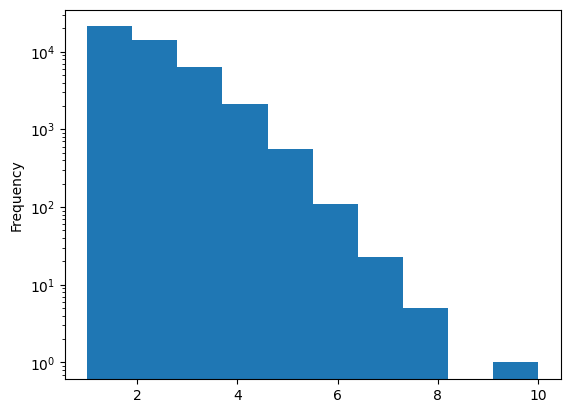

In [4]:
# Look at the percentage of rows that are historical records of no-shows
print("no_show:")
print(df['no_show'].value_counts(normalize=True))

# Look at the number of clinic locations
print()
print('Number of Clinic Locations: ' + str(df['Clinic Location'].nunique()))

# Examine the number of neighborhoods the patients live in
print()
print('Number of Neighborhoods: ' + str(df['Neighborhood'].nunique()))

# Plot the number of appointments per patient
# Notice that most appointments are from patients that are new or have few historical appointments
print()
print('Patient ID:')
df['Patient ID'].value_counts().plot(kind='hist', logy=True)


Looking at the feature list, it details a few interesting facts:

- **no_show** is the target variable. Roughly 4 percent of the visits were no-show visits.
- **Patient ID** represents the patient going to the appointment. The data contains multiple visits for one patient; therefore, you should choose the **Group Partitioning** method when loading the data into DataRobot.
- **Clinic location** is one of the nine clinic locations the patient visits.
- **Neighborhood** is one of the 37 neighborhoods in San Francisco that the patients live in. Calculating the distance between the patient neighborhood and the clinic would be extremely useful.
- **Appointment date & schedule date** are event dates (the date and the time in the case of appointment date). Engineering a feature that calculates the difference between these dates would also be useful.

## Feature engineering

As mentioned above, engineering a few features will help the dataset tremendously. Specifically:

- With appointment date and the schedule date, calculate the real insight&mdash;the elapsed time, in days, between the two dates.
- The distance between where the patient lives and the clinic that is being visited.
- Historical no-show rates per patient.

There are many tools available to calculate these features. This example uses Python and Pandas to peform some simple calculations.

#### Appointment date and schedule date
In this section you calculate the difference, in days, between when the appointment was scheduled and when it occured. Add this difference as a feature so DataRobot can use it when building a model. This feature will be represented by the column **Appointment/Schedule Delta**.

In [5]:
# Change the schedule date and appointment date from strings to dates
df['Schedule Date'] = pd.to_datetime(df['Schedule Date'])
df['Appointment Date'] = pd.to_datetime(df['Appointment Date'])

# Calulate the schedule delta between the scheduled day and the appointment day
# Empty out the time so you are just left with days
df["Appointment/Schedule Delta"] = (df['Appointment Date'] - df['Schedule Date'].apply(lambda t : t.replace(minute=0, hour=0, second=0, microsecond=0))).apply(lambda t: t.days)

#### Distance to appointment

Next, calculate the distance between the two locations. This accelerator includes two additional datasets that will help to enrich the data:

1. [planning_neighborhoods.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/planning_neighborhoods.csv) -- The neighborhoods of San Francisco and their WKT geodata polygons.
1. [clinics.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/clinics.csv) -- The latitude and longitude of the clinics.

The following cell adds a new column, **Distance**. The distance is calculated as the geo distance between the centroid of the neighborhood the patient lives in to the location (latitude/longitude) of the clinic. The neighborhood and clinic names remain in the final dataset as they may be meaningful to the data. 

In [6]:
# Create a map of neighborhood to the geometry of that neighborhood.
geo_df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/planning_neighborhoods.csv')
geo_df = geo_df.reset_index()
geo = {}

for index, row in geo_df.iterrows():
    geo[row['neighborho']] = row['the_geom']
    
# Create a map of clinic locations using the latitude and longitude of the clinic
clinic_df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/clinics.csv')
clinic_df = clinic_df.reset_index()
clinic = {}

for index, row in clinic_df.iterrows():
    clinic[row['name']] = [row['lat'], row['long']]

In [7]:
# Calculate the distance between the neighborhood and the clinic location
def calcDistance(neigh, loc):
    # Load the geometry (WKT format)
    p = shapely.wkt.loads(geo[neigh])
    lat = clinic[loc][0]
    long = clinic[loc][1]
    # Convert the lat/long into a point
    point = shapely.geometry.Point(long, lat)
    # Calculate the distance between the centroid of the neighborhood and the point of the clinic
    return p.distance(point)

# Add a new column that is the distance between the neighborhood and the clinic
df['Distance'] = df.apply(lambda l: calcDistance(l['Neighborhood'], l['Clinic Location']), axis=1)

#### Historical no-show rates

Next, load and calculate the historical no-show rates for each patient. For this example, assume that all historical data is stored in a CSV file keyed off of the Patient ID. (You would likely fetch these into a CSV or query a database.)

The historical data is included in [no_show_historical.csv](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/no_show_historical.csv).

In [8]:
# Create a map of patient IDs to historical no show rates
hist_no_show_df = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/no_show_historical.csv')
hist_no_show_df = hist_no_show_df.reset_index()
hist_no_show = {}

for index, row in hist_no_show_df.iterrows():
    hist_no_show[row['Patient ID']] = row['no_show']

In [9]:
# Add a new column that has the historical no show rate for that patient, or 0.0 if youe don't have the data
df['Hist No Show'] = df['Patient ID'].apply(lambda l: hist_no_show.get(l, 0.0))

In [10]:
# fDrop the column "Appointment ID" as it will have no meaning in DataRobot
df = df.drop(columns=['Appointment ID'])

### Final dataset

The final dataset, with all features, is:

In [11]:
df.info()
pd.set_option('display.max_rows', 5)
display(df.loc[df['no_show'] == False])
display(df.loc[df['no_show'] == True])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   no_show                     80000 non-null  bool          
 1   Patient ID                  80000 non-null  object        
 2   Gender                      80000 non-null  object        
 3   Age                         80000 non-null  int64         
 4   Alcohol Consumption         80000 non-null  object        
 5   Hypertension                80000 non-null  bool          
 6   Diabetes                    80000 non-null  bool          
 7   Appointment Date            80000 non-null  datetime64[ns]
 8   Schedule Date               80000 non-null  datetime64[ns]
 9   Appointment Reason          80000 non-null  object        
 10  Clinic Location             80000 non-null  object        
 11  Specialty                   80000 non-null  object    

,no_show,Patient ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,Appointment/Schedule Delta,Distance,Hist No Show
0,False,649e3901-e56b-41d9-b2d3-f61ce708a415,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill,80,0.035496,0.00
1,False,3028fd02-a20a-4233-ac16-b571dde4540c,F,37,0/week,False,True,2021-02-17 14:00:00,2021-01-25,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,23,0.072859,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79998,False,3570b112-021d-44da-be37-d2f76274ac90,F,41,5/week,False,False,2020-07-06 15:30:00,2020-06-17,ELECTROCARDIOGRAM REPORT,Mission Bay,Antenatal Testing Center,Ocean View,19,0.072859,0.00
79999,False,d066a33a-f9b8-40e9-9188-704e243202f8,F,36,5/week,False,False,2021-09-08 10:30:00,2021-07-20,"OFFICE/OUTPATIENT VISIT EST,LOCM 300-399mg/ml ...",Laurel Village,Primary Care at Laurel Village,Outer Mission,50,0.051993,0.26


,no_show,Patient ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,Appointment/Schedule Delta,Distance,Hist No Show
89,True,bdf1e07e-2e60-44d7-8ccb-0a485a0bdb5b,F,58,5/week,True,False,2021-05-14 15:45:00,2021-02-17,OFFICE/OUTPATIENT VISIT EST,Mount Zion,High-Risk Skin Cancer Clinic,Excelsior,86,0.054118,0.00
153,True,74152ac2-673f-4a12-9062-e01122d2af0f,M,47,> 14/week,False,False,2021-04-27 11:00:00,2021-02-01,SUBSEQUENT HOSPITAL CARE,Mission Bay,Human Performance Center,Presidio,85,0.061707,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79958,True,f7f896bf-266f-42f0-acb8-9f1844c61cec,F,36,0/week,False,False,2020-10-02 16:00:00,2020-06-15,Chest x-ray 2vw frontal&latl,Parnassus,California Center for Pituitary Disorders,Lakeshore,109,0.028724,0.30
79961,True,715f74a8-325b-4b39-b28b-7722111abb58,M,56,0/week,False,False,2020-07-28 09:45:00,2020-03-17,"OFFICE/OUTPATIENT VISIT EST,Ferumoxytol non-esrd",Mount Zion,Pain Management Center,Excelsior,133,0.054118,0.25


### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [12]:
# Create a client connection to DR
dr.Client()

### Import data

The final dataset now needs to be loaded into DataRobot via the API. Alternatively, you can modify the code above to save the final dataset as a CSV and use it to create a project in DataRobot.

In [13]:
# Write out the final version of the dataset
ct = datetime.datetime.now()
file_name = f"no_show_enriched_{int(ct.timestamp())}.csv"

dataset = dr.Dataset.create_from_in_memory_data(df)
dataset.modify(name=file_name)

dataset

#df.to_csv("./" + file_name, index=False)

Dataset(name='no_show_enriched_1686808642.csv', id='648aa84ae0838f6f81bbcb2b')

## Modeling

### Create a DataRobot project

Now it is time to create a project in DataRobot. There are a couple of ways this could be done. It could be loaded using the UI or, as the following code shows, it can be done using the DataRobot API.

**Note:** Choose the following settings from the UI if you are creating the project manually.

- Choose the feature **no_show** as the target feature.

- Choose **Group** partitioning (**Advanced options > Partitioning group**) and set the **Group ID Feature** to **Patient ID**.

- Create a new feature list that excludes **Approval Date** and **Schedule Date** to control which features are used in model creation. Specifically, the list will keep the components of the **Approval Date** and **Schedule Date**, but does not keep the dates themselves.

The following code creates the project in DataRobot with the correct settings.

In [14]:
# Create the project
ct = datetime.datetime.now()
project_name = f"no_show_enriched_{int(ct.timestamp())}"

project = dataset.create_project(project_name=project_name)

In [15]:
# Now create a new feature list that contains all of the "Informative Features" in the project
# This feature list will contain all derived features DataRobot created for you
flists = project.get_featurelists()
flist = next(x for x in flists if x.name == "Informative Features")

# You don't want dates in the feature list, just the components created by DataRobot
new_features = [x for x in flist.features if x not in ['Appointment Date','Schedule Date']]

# Create the new feature list in DataRobot
fl = project.create_featurelist(name='No Dates', features=new_features)

# Uncomment the next line to print out a link that can be used to access the project UI in DataRobot
#display(HTML(f'At this point you can <a target="_blank" rel="noopener noreferrer" href="https://app.datarobot.com/projects/{project.id}/eda">click into the project</a> and look at the features. Notice the new feature list we created.'))

### Start Autopilot

Next, set your project options, target, partitioning method, and feature list. Then you will start Autopilot and wait for it to finish.

In [16]:
group_cv = dr.GroupCV(20, 5, ['Patient ID'])

project.analyze_and_model(
    # Set the target as the no_show column
    target='no_show',
    # Don't limit the worker count
    worker_count = '-1',
    # Group partition on the Patient ID column
    partitioning_method=group_cv,
    mode=dr.AUTOPILOT_MODE.QUICK,
    # Set the feature list that was created above
    featurelist_id=fl.id
)

# Uncomment the next line to print out a link that can be used to access the project UI in DataRobot
#display(HTML(f'Now you can navigate to the models page of the new project or <a target="_blank" rel="noopener noreferrer" href="https://app.datarobot.com/projects/{project.id}/models">click this link</a>'))

project.wait_for_autopilot(verbosity=0)

### Navigate to project in the UI

Once the project is created and Autopilot has finished, you should navigate to the project in the UI. Use the following cell to retrieve the name of the project.

In [17]:
print(project_name)

no_show_enriched_1686808709


## Analyze models

### Exploratory Data Analysis

Navigate to the **Data** tab to learn more about your data.

- Click each feature to see a histogram that represents the relationship of the feature with the target.

- The Feature Associations tab visualizes clusters of related columns.

### Leaderboard

You can click on the **Models** tab to view the Leaderboard and see generated models as they build.

From the Leaderboard, click on any model to reveal the blueprint&mdash;the pipeline of preprocessing steps, modeling algorithms, and post-processing steps. Autopilot will continue building models until it selects the best predictive model for the specified target feature. This model is at the top of the Leaderboard, marked with the **Recommended for Deployment** badge.

Please see the [DataRobot documentation](https://app.datarobot.com/docs/modeling/analyze-models/index.html) for more information. 

### Evaluation

After you have clicked on a model, under the **Evaluate** tab, view the ROC Curve. The information here can be used to calculate the ROI of the solution. ROI is directly related to how you operationalize the model. 

For this use case, the goal is to build a call list that results in changing the outcome for patients that might not have shown up, while minimizing the number of people called that would have attended without prompting. You can do so by assigning payoffs for the **True Positives** and **False Positives** of the payoff matrix.

- Choose **Add Payoff** in the Matrix pane and enter values for True Positive and False Positive. For example: TP=`$120` and FP=`-$5`
- For metrics, select False Positive Rate (Fallout), Positive Predictive Value (Precision), and Average Profit.

<img src="https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/img/matrix.png" style="padding:5px;"/>

Choosing a True Positive payout of `$120` indicates saving `$120` for every patient that shows up once called. A false positive payout of `-$5` reflects the cost of `$5` to make the call.

The decision boundary suggested for max profit is not practical because almost 20% of appointments (the Fallout rate) would require a personalized reminder. Adjust where on the curve to set that target for the model.

- Click on different points of the ROC curve to see what the recall rate looks like for Fallout values of 5% and 10%.
- At 5%, the precision is roughly 27% and average profit is roughly \\$3
- At 10%, the precision is roughly 21% and the average profit is roughly \\$3.40

<img src="https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/img/cmatrix.png" style="padding:5px;"/>

Choosing a **Fallout** of roughly 6% gives a proffit of roughly `$3` which is in range for this use case.

### Insights

There are many ways within DataRobot to veiw insights into why a patient might not show. Below are the most relavent for this use case, all found under the **Understand** tab of the Leaderboard.

#### Feature Impact
**Feature Impact** is one way to view which features are driving model decisions. A large impact means model performance deteriorates significantly when this feature is removed. Features with low impact may still contribute to the model.

For this use case `Hist No Show`, `Appointment/Schedule Delta`, `Distance`, `Appointment Reason`, and `Alcohol Consumption` are the most impactful features. 

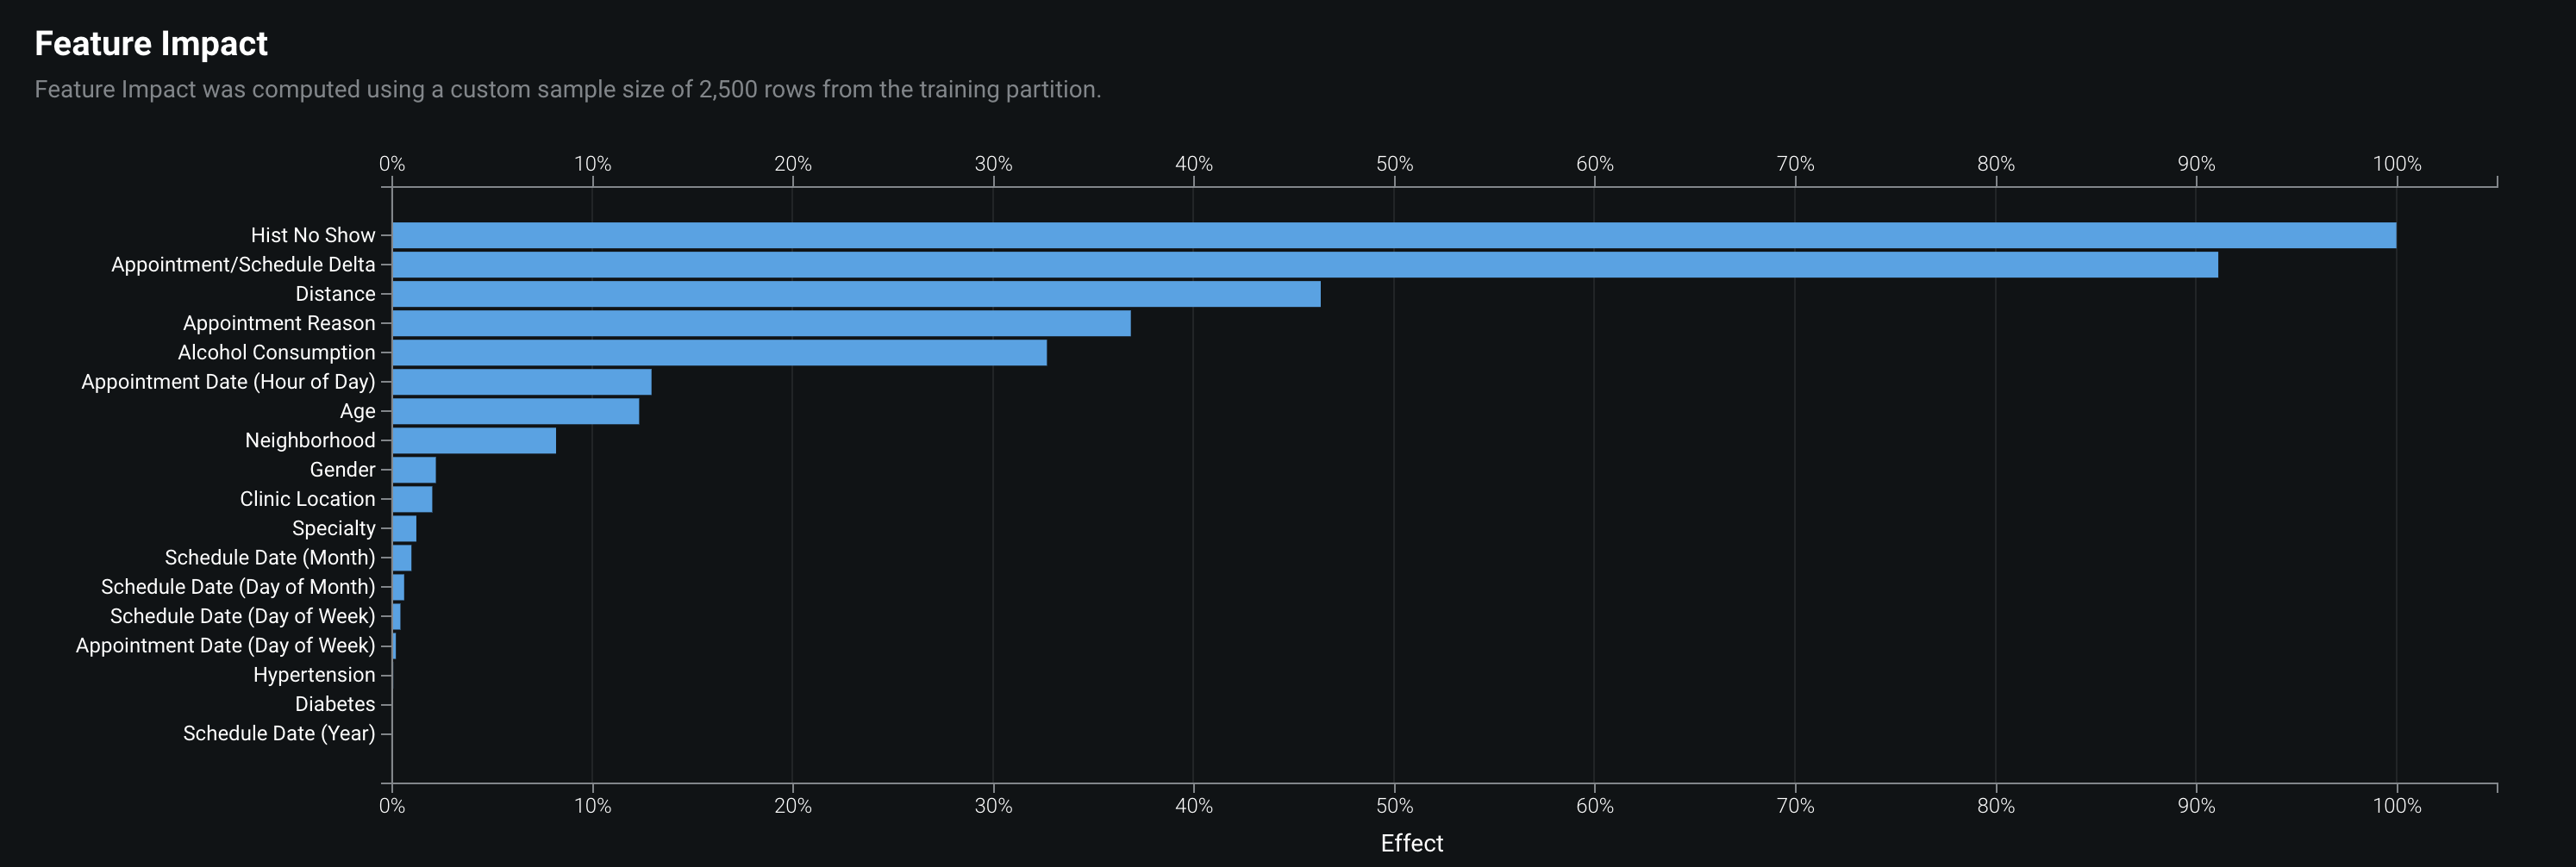

One would agree that these features are likely the features that would impact if someone will show up for an appointment. For example, if that person has a history of not showing up then it makes sense to predict they won't in the future.

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) for more information on how to interpret this section.

#### Feature Effects

**Feature Effects** shows how a model is effected when a the value of a feature changes. For this use case:

- For `Appointment Delta`, a larger disparity between dates increases the likelihood of a no-show.
- For `Distance`, further distance from the clinic increases the likelihood of a no-show.

<img src="https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/img/fe.png" style="padding:5px;"/>

The image above is showing the feature effects that the `Distance` feature has on results. Notice that the farther away a patient is from the clinic the less likely they are to show up for their appointment.
    
See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-effects.html) for more information on how to interpret this section.

#### Prediction Explanations

**Prediction Explanations** provide the drivers behind each prediction.

<img src="https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/img/pe.png" style="padding:5px;"/>

For the row in the image above, `Hist No Show`, `Appointment/Schedule Delta`, and `Distance` are the features contributing most to the reason the model predicts this row to be a no-show.

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/pred-explain/index.html) for more information on how to interpret this section.

#### Word Cloud

The word cloud allows you to explore how text fields affect predictions. 

<img src="https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/img/wordcloud.png" style="padding:5px;"/>

In this use case, patients that have `new` in the reason for the visit are the least likely to show up.

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/word-cloud.html) for more information on how to interpret this section.

### Compliance

If available for your organization, from the **Compliance** tab you can compile model development documentation, in MS Word format, that can be used for regulatory validation.

See the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/compliance/index.html) for more information on how to interpret this section.

## Make predictions

Once you understand and have selected a model, it can be deployed. This example deploys the recommended model (marked with a badge) from the Leaderboard. You can deploy in the UI from the model's **Predict > Deploy** tab or using Python, as shown below.

In [18]:
# Get the recommended model
model_depl = dr.ModelRecommendation.get(project.id).get_model()

pred_serv_id = dr.PredictionServer.list()[0].id
deployment = dr.Deployment.create_from_learning_model(model_id=model_depl.id, 
                                                      label=f'{project_name}_depl',
                                                      default_prediction_server_id=pred_serv_id)

In [19]:
deployment.update_association_id_settings(column_names=['Appointment ID'], required_in_prediction_requests=True)
deployment.update_drift_tracking_settings(True, True)

In [20]:
# Generate explanations

# To compute Feature Impact:
feature_impacts = model_depl.get_or_request_feature_impact()

# To initialize Prediction Explanations:
pei_job = dr.PredictionExplanationsInitialization.create(project.id, model_depl.id)
pei_job.wait_for_completion()

The following lines of code predict no-shows for January. It will generate a list of patients that should be called for that month.

You can read more about configuring batch predictions in [DataRobot's Python client documentation.](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/predictions/batch_predictions.html)

In [21]:
# First set the display options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)

df_scoring_csv = pd.read_csv('https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/jan_sample.csv')
df_scoring = data_prep_sample(df_scoring_csv)

job, results_df = dr.BatchPredictionJob.score_pandas(deployment, 
                                              df_scoring,
                                              max_explanations = 3)

results_df.loc[results_df['no_show_PREDICTION'] == True].head()

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 648aabdf32e7c4333cbb704c
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


,Unnamed: 0,Patient ID,Appointment ID_x,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,Hist No Show,Appointment/Schedule Delta,Distance,no_show_True_PREDICTION,no_show_False_PREDICTION,no_show_PREDICTION,THRESHOLD,POSITIVE_CLASS,EXPLANATION_1_FEATURE_NAME,EXPLANATION_1_STRENGTH,EXPLANATION_1_ACTUAL_VALUE,EXPLANATION_1_QUALITATIVE_STRENGTH,EXPLANATION_2_FEATURE_NAME,EXPLANATION_2_STRENGTH,EXPLANATION_2_ACTUAL_VALUE,EXPLANATION_2_QUALITATIVE_STRENGTH,EXPLANATION_3_FEATURE_NAME,EXPLANATION_3_STRENGTH,EXPLANATION_3_ACTUAL_VALUE,EXPLANATION_3_QUALITATIVE_STRENGTH,DEPLOYMENT_APPROVAL_STATUS,Appointment ID_y
6,6,bf978545-1275-45c2-8ed9-f69ae156771c,1eb56386-3499-471e-93f8-98d663a9bd1d,F,17,0/week,False,False,2022-01-31 08:30:00,2021-08-03 00:00:00,"OFFICE/OUTPATIENT VISIT NEW,Daptomycin injecti...",Parnassus,Infusion Center,Outer Mission,0.25,181,0.051588,0.508578,0.491422,True,0.5,True,Appointment Reason,1.337003,"OFFICE/OUTPATIENT VISIT NEW,Daptomycin injecti...",+++,Hist No Show,1.235433,0.25,+++,Appointment/Schedule Delta,1.175570,181,+++,APPROVED,1eb56386-3499-471e-93f8-98d663a9bd1d
33,33,806f594a-997c-4278-8544-7dbdd8a46fc2,440d8da1-f69e-4d1f-b75f-46a318a4c01b,M,55,> 14/week,False,False,2022-01-06 09:30:00,2021-08-17 00:00:00,"THERAPEUTIC EXERCISES,Inj testosterone cypionate",Mount Zion,Mammography Screening,Parkside,0.36,142,0.059132,0.634147,0.365853,True,0.5,True,Appointment/Schedule Delta,1.414675,142,+++,Hist No Show,1.249752,0.36,+++,Alcohol Consumption,1.017528,> 14/week,++,APPROVED,440d8da1-f69e-4d1f-b75f-46a318a4c01b
121,121,717442f1-e0ba-4f27-a0ce-cc1ff96de253,bd2dd6b6-0b35-444e-92fa-20c1f7595ae9,M,41,> 14/week,False,False,2022-01-19 08:00:00,2021-07-19 00:00:00,THERAPEUTIC EXERCISES,Parnassus,Neuro/Psych Sleep Clinic,Outer Richmond,0.17,184,0.096210,0.668767,0.331233,True,0.5,True,Appointment/Schedule Delta,1.415882,184,+++,Hist No Show,1.256081,0.17,+++,Alcohol Consumption,0.931668,> 14/week,++,APPROVED,bd2dd6b6-0b35-444e-92fa-20c1f7595ae9
177,177,c4cc388f-0b62-4339-b8ad-06146036114e,a836bf05-aca4-4d90-8e53-bf03cbf3f7bb,M,42,> 14/week,False,False,2022-01-04 08:00:00,2021-08-06 00:00:00,"OFFICE/OUTPATIENT VISIT EST,Paclitaxel injection",Mount Zion,Osher Center for Integrative Medicine,Glen Park,0.21,151,0.053679,0.558122,0.441878,True,0.5,True,Appointment/Schedule Delta,1.329059,151,+++,Hist No Show,1.215514,0.21,+++,Alcohol Consumption,0.961447,> 14/week,++,APPROVED,a836bf05-aca4-4d90-8e53-bf03cbf3f7bb


Each table above is showing patients who possibly will not show up to their next appointment. These results can be used in a separate application or integreting with another system. Either way the code above shows how that call list can be generated.

## Functionality overview

The following DataRobot functionality was employed in this use case:

|FEATURE|BENEFIT|
|-------- | -----------|
|Group Partitioning|Used to group the input data by patient ID.|
|Feature Lists|Used to remove dates from the input features for DataRobot.|
|Profit Curve|Helps to optimize the cost of a bad prediction vs. the value of a good one.|
|Prediction Explanations|Generates explanations that contribute to each score.|
|Word Cloud|Helps to explain what visit codes contribute to no-show appointments.|


## Copyright / License

All datasets are Copyright 2022 DataRobot, Inc. All rights reserved.

All datasets are distributed under the [DataRobot Tool and Utility License](https://www.datarobot.com/wp-content/uploads/2021/07/DataRobot-Tool-and-Utility-Agreement.pdf)